In [14]:
import tweepy as TW
import pandas as pd
import nltk
import re
import datetime as dt
# connect to twitter API

CONSUMER_KEY = 'XkmU3czKdJ1jfzUAIWELFC9y8'
CONSUMER_SECRET = 'HlxpwfuShIh8OXRGjWgT2h3fD9JMC6HNtQ11N28WFFDzpCUHO0'
ACCESS_TOKEN = 	'4826647649-GRcsvzCoPjdTdosCCgYY9zalhBytNbSuVaemIvH'
ACCESS_TOKEN_SECRET = '93l4Mh1KLfexPNxwqZ4mtjUhseGWe5xQecS0Sd7YfdCbm'

auth =TW.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)  
api = TW.API(auth)


def parsingTwitter():
    data = {'date': [], 'text': []}

    for tweet in TW.Cursor(api.search, 
                        q="blockchain",                       
                        since="2017-06-10", 
                        until="2017-08-10", 
                        lang="en").items(700):   

            data['text'].append( tweet.text)
            data['date'].append(tweet.created_at)
    
    #Оберточка дикт в пандас
    data = pd.DataFrame(data)
    data.text = data.text.drop_duplicates()
    data = data.dropna()
    return data
    

## Filter dataframe

In [2]:
stop_list = nltk.corpus.stopwords.words('english') + ["rt"] + ['[slides]']+ ["re"]

lemmatizer = nltk.stem.WordNetLemmatizer()
reg = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'

emoji_pattern = re.compile(u'('
    u'\ud83c[\udf00-\udfff]|'
    u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
    u'[\u2600-\u26FF\u2700-\u27BF])+', 
    re.UNICODE)


def preprocess(tweet):   

    tweet = tweet.lower()
    #tweet = " ".join(tweet.split('#'))
    tweet = re.sub('((www\.[^\s]+)|(https://[^\s]+))','',tweet)
    tweet = re.sub('((pic\.[^\s]+)|(https://[^\s]+))','',tweet)
    tweet = re.sub("(http\S+)|(https\S+)", '', tweet)
    tweet = re.sub(reg,'',tweet)
    #tweet = re.sub(u'[a-zA-Z0-9./]+\.[a-zA-Z0-9./ ]+.*$','',tweet)
    
    tweet = re.sub(u'[\(\)]',' ',tweet)
    tweet = re.sub(u'\n',' ',tweet)
    tweet = re.sub(u'@[^\s]+','',tweet)  
    tweet = re.sub(r'#[^\s]+', '', tweet)
    tweet = tweet.strip('\'"')
    twitter = emoji_pattern.sub('', tweet)
    tweet = re.sub('[\W]', ' ', tweet)
    
    # Removing stop words 
    tweet  = " ".join([word for word in tweet.split(" ") if word not in stop_list])
    tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split(" ")])
    return tweet


# Semantic analise

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def makeSentimentAnalyse(data):
    sid = SentimentIntensityAnalyzer()
    s_analisys_dataframe = pd.DataFrame()

    for i in data.index:
        ss = sid.polarity_scores(data.processed_text[i])
        ss['date'] = data.date[i]
        returnDF = pd.DataFrame(pd.Series(ss,index=ss.keys())).T
        s_analisys_dataframe = s_analisys_dataframe.append(returnDF, ignore_index=True)
    return s_analisys_dataframe

/root/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Prepare Dataframe

In [84]:
def prepareDataframe(dataframe):
    start_time = dataframe.date.min().floor('d')
    end_time = dataframe.date.max()
    
    returned_df = {'date': [],'neg':[], 'neu':[],'pos':[], 'compound':[]}#
    
    for i in pd.date_range(start_time, end_time):

        df_new = dataframe[(dataframe['date'] >= i) \
                            & (dataframe['date'] < i+ dt.timedelta(1))].mean()
        
        returned_df['date'].append(i)
        returned_df['neg'].append(df_new.neg)
        returned_df['neu'].append(df_new.neu)
        returned_df['pos'].append( df_new.pos)
        returned_df['compound'].append(df_new['compound'])
        
    return pd.DataFrame(returned_df)

## Construct model


In [5]:
from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential, load_model, save_model

input_dim = 1
NN_initialisation = 'uniform'
NN_activation = 'relu'
NN_loss = 'mean_squared_error'

def buildModel_NN():
    model=Sequential()
    model.add(Dense(32,input_dim=input_dim,init=NN_initialisation,activation=NN_activation))
    model.add(Dense(32,input_dim=input_dim,init=NN_initialisation,activation=NN_activation))
    model.add(Dense(16,init=NN_initialisation,activation=NN_activation))
    
    model.add(Dense(1,init=NN_initialisation,activation=NN_activation))
    model.compile(loss = NN_loss,optimizer='adam',metrics=['accuracy'])


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [95]:
#############################
# ТЕСТОВЫЙ ПРОГОН
#########"
from dateutil import parser
import matplotlib.pyplot as plt
import src.get_data as get_data
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 
tweet = pd.read_csv('./data/news.csv', names=['id','date', 'time', 'tweet', 'comp', 'neg', 'neu','pos', 'REQUEST'])

data = tweet[['date', 'tweet']].copy()
data.date = [parser.parse(x) for x in data.date]
data['processed_text'] = part_tweet_df.tweet.apply(preprocess)

s_analisys_dataframe = makeSentimentAnalyse(data)
data_twitter = prepareDataframe(s_analisys_dataframe)

df = get_data.get_data_frame() 

dataframe_for_analise = pd.concat([df, data_twitter], axis = 1, ignore_index=False).dropna()

# Шклалируем данные  

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

features = ['compound','neg','neu','pos'] # набор фич, по которым будем делать предсказания

x = dataframe_for_analise[features].copy() 
x = x_scaler.fit_transform(x)
NUM_FEATURES = x.shape[1]

y = dataframe_for_analise['close'].copy() 
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

x = pd.DataFrame(x)
y = pd.DataFrame(y)
(x.plot())
y.plot()
plt.show()


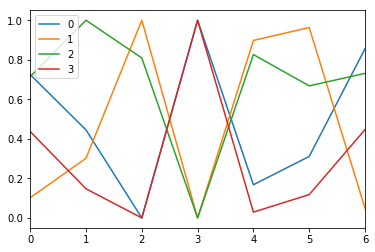

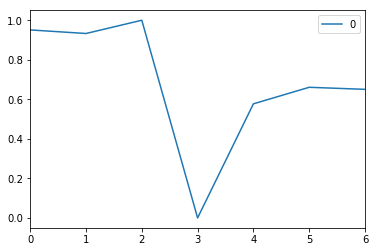

## Основная моделька

In [300]:
import src.load_data
import src.get_data as get_data

from sklearn.preprocessing import MinMaxScaler

# Парсим данные с твиттера

data = parsingTwitter()
data['processed_text'] = data.text.apply(preprocess)
s_analisys_dataframe = makeSentimentAnalyse(data)
data_twitter = prepareDataframe(s_analisys_dataframe)


# Обращаемся в базу за значениями цены закрытия и 
# собираем датафрейм для анализа

df = get_data.get_data_frame() 

df = df[['close','date']]
df.index = df.date
df = df['close']
data_twitter.index = data_twitter.date
data_twitter = data_twitter[['compound','neg','neu','pos']]

dataframe_for_analise = pd.concat([df, data_twitter], axis = 1, ignore_index=False).dropna()

# Шклалируем данные  

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

features = ['compound','neg','neu','pos'] # набор фич, по которым будем делать предсказания

x = dataframe_for_analise[features].copy() 
x = x_scaler.fit_transform(x)
NUM_FEATURES = x.shape[1]

y = dataframe_for_analise['close'].copy() 
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
x['close'] = y

# Разбиваем данные на тренировочные и тестовые

X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)

x = x[features]

# Вызываем сбор модели для обучения
model = buildModel_NN()

history = History()
history= model.fit(X_train, y_train, validation_data=(X_test, y_test), \
                   batch_size=32, epochs=500,verbose=0, callbacks=[history])

In [ ]:
today = time.strftime("_%d_%m_%Y")
    
pathModel = "twitter_model_" +".h5"
save_model(model, pathModel)

astbatch = np.array(x[-WINDOW:])
pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
pred =  np.array(y_scaler.inverse_transform(pred)) 